# SYNTHETIC DATASET

With this notebook we will be able to create a synthetic dataset that will be used for training, validating and testing our model.

The notebook will allow the customization of input parameters that will be reflected in the generated dataset.

Output will be saved by default under the 'dataset' folder, conflicting files will be overriden.

## Desired Output

Following the work done by 'benedekrozemberczki' which can be found in the [following repository](https://github.com/benedekrozemberczki/SimGNN), we decided to adopt the same JSON structure when saving our dataset points (examples). Thus we create an helper class which will be dumped to a JSON file at time.

NOTE: We are not including any 'label' properties because we decided to work with unlabeled nodes only.

In [1233]:
from dataclasses import dataclass
from typing import List

@dataclass
class DatasetPoint:
    graph_1: List[List[int]] # List of edges which represents a graph, e.g: [[0, 8], [0, 5], [0, 2]...] 
    graph_2: List[List[int]] # List of edges which represents a graph, e.g: [[1, 3], [1, 5], [2, 4]...] 
    ged: int                 # The precise graph edit distance between graph_1 and graph_2, eg: 13

## Graph Manipulation

All the part related to manipulating graphs will be handled by [NetworkX](https://networkx.org/) library.

In [1234]:
import networkx as nx
from random import randint
from random import uniform

# Erdős-Rényi
def generate_random_ER_graph():
    n  = randint(1, 10) # Number of nodes
    p = uniform(0.1, 1.0) # Probability for edge creation
    G = nx.gnp_random_graph(n, p, seed=None, directed=False)
    return G

# Barabási–Albert
def generate_random_BA_graph():
    n  = randint(2, 10) # Number of nodes
    m = randint(1, n-1) # Number of edges to attach from a new node to existing nodes,
    if not (m >= 1 and m < n):
        raise Exception(f"m >= 1 and m < n", f"m={m}", f"n={n}")
    G = nx.barabasi_albert_graph(n, m, seed=None, initial_graph=None)
    return G

## WIP

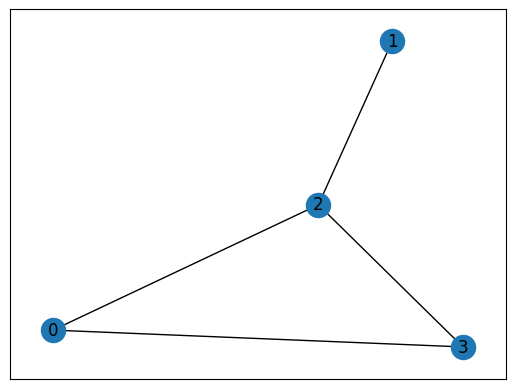

In [1235]:
G = generate_random_ER_graph()
nx.draw_networkx(G)

In [1236]:
def add_random_node(G : nx.Graph):
    nodes = list(G.nodes)
    new_node = nodes[-1] + 1
    G.add_node(new_node)
    print(f'add_node {new_node}')
    return G, 1

def remove_random_node(G : nx.Graph):
    nodes = list(G.nodes)
    if len(nodes) == 0:
        # Graph may have 0 nodes
        return G, 0
    rand = randint(0, len(nodes) - 1)
    rmv_node = nodes[rand]
    neighbors = list(G.neighbors(rmv_node))
    G.remove_node(rmv_node)
    print(f'remove_node {rmv_node}')
    return G, len(neighbors) + 1

def add_random_edge(G : nx.Graph):
    nonedges = list(nx.non_edges(G))
    if len(nonedges) == 0:
        # Graph may be complete
        return G, 0
    rand = randint(0, len(nonedges) - 1)
    new_edge = nonedges[rand]
    G.add_edge(*new_edge)
    print(f'new_edge {new_edge}')
    return G, 1

def remove_random_edge(G : nx.Graph):
    edges = list(G.edges)
    if len(edges) == 0:
        # Graph may have 0 edges
        return G, 0
    rand = randint(0, len(edges) - 1)
    rmv_edge = edges[rand]
    G.remove_edge(*rmv_edge)
    print(f'remove_edge {rmv_edge}')
    return G, 1

def apply_atomic_random_operation(G : nx.Graph):
    """
    Randomly apply one atomic operation on the graph in input:
    - Add a random node
    - Delete a random node (and its neighbors's edges)
    - Add a random edge
    - Delete a random edge
    
    Returns:
    A tuple (G, distance) where: 
    - G is the modified graph
    - distance: is the distance from the original graph after the modification
    """
    operation = randint(1,4)
    if operation == 1:
        return add_random_node(G)
    elif operation == 2:
        return remove_random_node(G)
    elif operation == 3:
        return add_random_edge(G)
    elif operation == 4:
        return remove_random_edge(G)

In [1237]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_two_graph_temp(G1, G2, distance):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    nx.draw(G1, with_labels=True, font_weight='bold', ax=axes[0])
    nx.draw(G2, with_labels=True, font_weight='bold', ax=axes[1])
    plt.tight_layout()
    plt.title(f"distance = {distance}")
    plt.show()

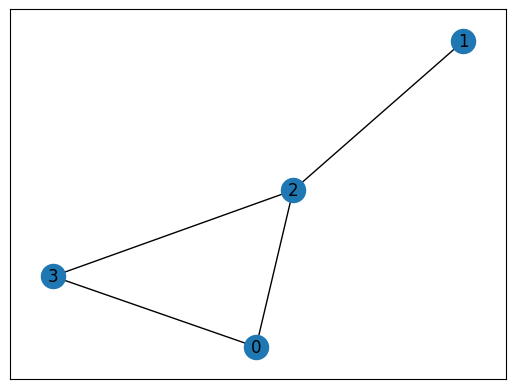

In [1238]:
nx.draw_networkx(G)

Graph with 4 nodes and 4 edges
remove_node 3
add_node 3
remove_node 0
add_node 4
new_edge (1, 3)
Graph with 4 nodes and 2 edges
Real distance = 2
My Distance = 8


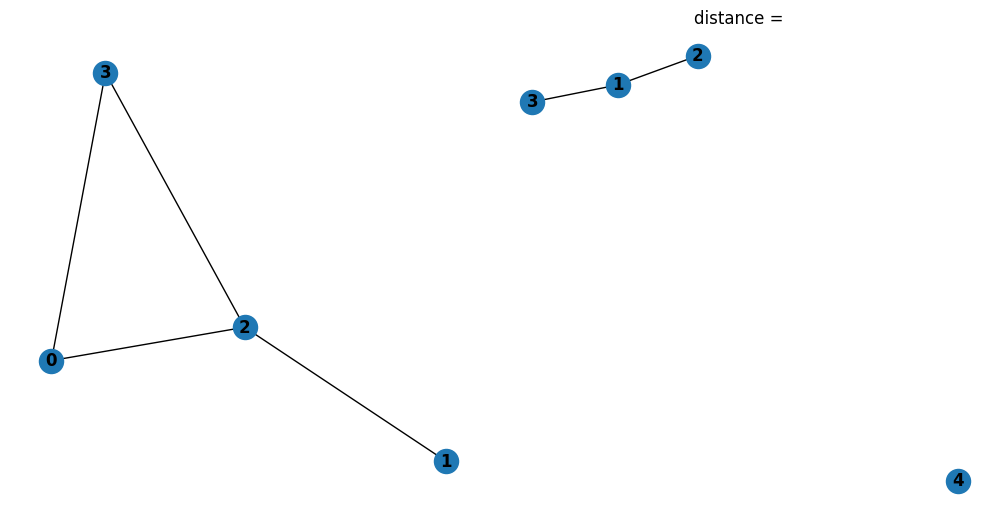

In [1239]:
from copy import deepcopy

print(G)

edited = deepcopy(G)
sum_distance = 0
# print(edited)

for i in range(0, 5):
    edited, distance = apply_atomic_random_operation(edited)
    sum_distance += distance
    # print(edited)
    
print(edited)

# draw_two_graph_temp(G, G2, distance)
ged = round(nx.graph_edit_distance(G, edited))
print(f"Real distance = {ged}")
print(f"My Distance = {sum_distance}")

draw_two_graph_temp(G, edited, "")


Non va bene fare i loop di atomic operations in questo modo.

Potrei fare prima una remove di un nodo.

Magari la mia ged aumenta di 5

Poi faccio una add, la mia ged aumenta di 1, ma se faccio l'add del nodo rimosso prima in realtà diminuisce di 1.

Stessa cosa con gli archi.

Non posso fare sia add che remove, o le une o le altre.

Devo partire da un grafo piccolo e poi ingrandirlo iterativamente, in questo modo preservo l'additività penso.

Inoltre ora sorge un altro problema, come faccio per confrontare la mia prima iterazione del grafo con la n? se sono additive ok....

riproviamo!

In [1240]:
def add_random_node(G : nx.Graph):
    nodes = list(G.nodes)
    new_node = nodes[-1] + 1
    G.add_node(new_node)
    return G, 1

def add_random_edge(G : nx.Graph):
    nonedges = list(nx.non_edges(G))
    if len(nonedges) == 0:
        # Graph may be complete
        return G, 0
    rand = randint(0, len(nonedges) - 1)
    new_edge = nonedges[rand]
    G.add_edge(*new_edge)
    return G, 1

def apply_atomic_random_operation(G : nx.Graph):
    """
    Randomly apply one atomic operation on the graph in input:
    - Add a random node
    - Add a random edge
    
    Returns:
    A tuple (G, distance) where: 
    - G is the modified graph
    - distance: is the distance from the original graph after the modification
    """
    operation = randint(1,100)
    if operation <= 15:
        return add_random_node(G)
    elif operation > 15:
        return add_random_edge(G)

Graph with 4 nodes and 4 edges
Graph with 14 nodes and 64 edges
Real distance = 70
My Distance = 70


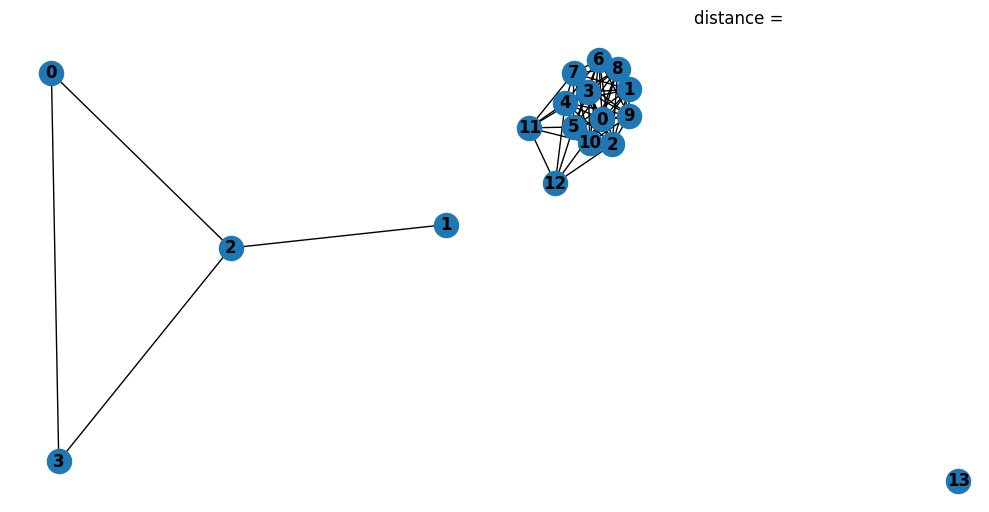

In [1241]:
from copy import deepcopy

print(G)

history = {0: (G,0)}
edited = deepcopy(G)
sum_distance = 0
# print(edited)

for i in range(1, 100):
    edited, distance = apply_atomic_random_operation(edited)
    if distance > 0:
        sum_distance += distance
        history[i] = (deepcopy(edited), distance)
    
print(edited)

# draw_two_graph_temp(G, G2, distance)
ged = round(nx.graph_edit_distance(G, edited))
print(f"Real distance = {ged}")
print(f"My Distance = {sum_distance}")

draw_two_graph_temp(G, edited, "")

assert ged == sum_distance

Quello che succede è che così ovviamenete funziona

Posso confrontare un grafo x con un grafo y dove x ha nodi che y non ha?

No se confronto grafo 1 con grafo x, con x > 1

ma se confronto grago x con grafo y, dove x != y e x,y sono random (eg. 52, 17) allora si.

Quindi cosi mi genero in modo incrementale i grafi (ad esempio 100 step)

Poi posso generarmi coppie random dalla history di questi 100 step (max)

quindi 4950 coppie (math.comb(100, 2))

A questo punto dovremmo stabilire dei criteri su come generare i vari grafi.

parto da un grafo A

Il grafo A può essere generato randomicamente con ER o BA avente n nodi, m, p, etc.

Sul grafo A, quanto operazioni atomiche di add faccio? (solo add o solo delete (sono simmetriche poi alla fine quando prendo le coppie))

Le operazioni atomiche non preservano la natura del grafo, diciamo che, teoricamente, meno operazioni faccio più sono simili.

In [1242]:
print(G)
print(edited)
history

Graph with 4 nodes and 4 edges
Graph with 14 nodes and 64 edges


{0: (<networkx.classes.graph.Graph at 0x1c999f01ed0>, 0),
 1: (<networkx.classes.graph.Graph at 0x1c999fd8af0>, 1),
 2: (<networkx.classes.graph.Graph at 0x1c999f04f10>, 1),
 10: (<networkx.classes.graph.Graph at 0x1c999e24d90>, 1),
 11: (<networkx.classes.graph.Graph at 0x1c999e26200>, 1),
 12: (<networkx.classes.graph.Graph at 0x1c999e24b80>, 1),
 13: (<networkx.classes.graph.Graph at 0x1c999e249d0>, 1),
 14: (<networkx.classes.graph.Graph at 0x1c999e268c0>, 1),
 15: (<networkx.classes.graph.Graph at 0x1c999e26950>, 1),
 16: (<networkx.classes.graph.Graph at 0x1c999e26170>, 1),
 17: (<networkx.classes.graph.Graph at 0x1c999e25fc0>, 1),
 18: (<networkx.classes.graph.Graph at 0x1c999e25e10>, 1),
 19: (<networkx.classes.graph.Graph at 0x1c999e25c60>, 1),
 20: (<networkx.classes.graph.Graph at 0x1c999e0d3f0>, 1),
 26: (<networkx.classes.graph.Graph at 0x1c999e0d5d0>, 1),
 27: (<networkx.classes.graph.Graph at 0x1c999df9e40>, 1),
 28: (<networkx.classes.graph.Graph at 0x1c999e259c0>, 1),


Verifichiamo l'additività della GED

Mi immagino che se G da history[0] ha GED 1, 
ed il grafo di history[1] ha ged di 1 dal grafo di history[0] allora G da history[1] ha ged 2

In [1243]:
def sum_ged_from_to_key(x,y):
    entries = history.items()
    sum = 0
    for entry in entries:
        iter = entry[0]
        if iter > x and iter <= y:
            ged = entry[1][1]
            sum += ged
    return sum

for entry in history.items():
    iter = entry[0]
    graph = entry[1][0]
    ged = entry[1][1]
    real = nx.graph_edit_distance(history[0][0], graph)
    estimated = sum_ged_from_to_key(0, iter)
    assert real == estimated
        


Additività verificata!!!!

generiamo le 4950 combinazioni a scopo didattico in modo non efficiente e proviamo ad ottnere un primo risultato scritto su json

recap: dato un grafo G, ho fatto 100 operazioni su di lui e mi salvo tutte le combinazioni.

In [1246]:
all_graphs = list(map(lambda v: v[0], history.values()))
all_indexes = list(history.keys())

from itertools import combinations

all_combinations = list(combinations(all_indexes, 2))


In [1247]:
points = []
for comb in all_combinations:
    graph_start = history[comb[0]][0]
    graph_end = history[comb[1]][0]
    # real = round(nx.graph_edit_distance(graph_start, graph_end))
    est = sum_ged_from_to_key(comb[0], comb[1])
    # assert real == est
    p = DatasetPoint(list(map(lambda t: list(t),graph_start.edges)), list(map(lambda t: list(t),graph_end.edges)), est)
    points.append(p)
    
points

[DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [1, 2], [2, 3]], ged=1),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [2, 3]], ged=2),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [2, 3]], ged=3),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [1, 4], [2, 3]], ged=4),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3]], ged=5),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [3, 4]], ged=6),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [0, 1], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [3, 4]], ged=7),
 DatasetPoint(graph_1=[[0, 2], [0, 3], [1, 2], [2, 3]], graph_2=[[0, 2], [0, 3], [

In [1248]:
import pandas as pd
df = pd.DataFrame(points)
df.to_csv("test.csv", index=False)
df

,graph_1,graph_2,ged
0,"[[0, 2], [0, 3], [1, 2], [2, 3]]","[[0, 2], [0, 3], [0, 1], [1, 2], [2, 3]]",1
1,"[[0, 2], [0, 3], [1, 2], [2, 3]]","[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [2, 3]]",2
2,"[[0, 2], [0, 3], [1, 2], [2, 3]]","[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [2, 3]]",3
3,"[[0, 2], [0, 3], [1, 2], [2, 3]]","[[0, 2], [0, 3], [0, 1], [1, 2], [1, 3], [1, 4...",4
4,"[[0, 2], [0, 3], [1, 2], [2, 3]]","[[0, 2], [0, 3], [0, 1], [0, 4], [1, 2], [1, 3...",5
...,...,...,...
2480,"[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...","[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...",2
2481,"[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...","[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...",3
2482,"[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...","[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...",1
2483,"[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...","[[0, 2], [0, 3], [0, 1], [0, 4], [0, 5], [0, 6...",2


In [1249]:
from json import dump
for idx, p in enumerate(points):
    dump(p, open(f'./dataset/graph_{idx}.json', 'w'), ensure_ascii=False, default=vars)
    